In [2]:
import pathlib
import numpy as np
from scipy import sparse
import pandas as pd
from sklearn.model_selection import KFold
from scipy.stats import pearsonr
from nilearn import plotting, maskers
from neuroquery import datasets
from neuroquery.img_utils import coordinates_to_maps
from neuroquery.smoothed_regression import SmoothedRegression
from neuroquery.tokenization import TextVectorizer
from neuroquery.encoding import NeuroQueryModel

from sklearn.model_selection import KFold
from neurovlm.loss import compute_metrics
from tqdm.notebook import tqdm

import sys
sys.path.append('/home/jerjes/repos/neurovlm/src/neurovlm')
# sys.path.append('/Users/ryanhammonds/projects/neurovlm')

import torch
from neurovlm.models import TextAligner
from neurovlm.train import Trainer

from neurovlm.data import get_data_dir
import nibabel as nib
import numpy as np

/home/jerjes/repos/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Neuroquery

In [3]:
# Load NeuroQuery data
data_dir = pathlib.Path(datasets.fetch_neuroquery_model())
corpus_metadata = pd.read_csv(str(data_dir / "corpus_metadata.csv"))
vectorizer = TextVectorizer.from_vocabulary_file(str(data_dir / "vocabulary.csv"))
tfidf = sparse.load_npz(str(data_dir / "corpus_tfidf.npz"))
coordinates = pd.read_csv(datasets.fetch_peak_coordinates())
print(f"Loaded {corpus_metadata.shape[0]} studies")

Loaded 13459 studies


In [4]:
# # coords to brain maps
# brain_maps, masker = coordinates_to_maps(
#     coordinates, target_affine=(6, 6, 6), fwhm=9.0
# )
# brain_maps = brain_maps[(brain_maps.values != 0).any(axis=1)]

# # Align TFIDF and brain maps (exactly like their notebook)
# pmids = brain_maps.index.intersection(corpus_metadata["pmid"])
# rindex = pd.Series(np.arange(corpus_metadata.shape[0]), index=corpus_metadata["pmid"])
# tfidf_final = tfidf.toarray()[rindex.loc[pmids].values, :]
# brain_maps_final = brain_maps.loc[pmids, :].values

# print(f"Final dataset: {len(pmids)} studies")
# print(f"TFIDF shape: {tfidf_final.shape}")
# print(f"Brain maps shape: {brain_maps_final.shape}")

# These were pre-computed from the neurocontext pmid set
neurovlm_data_dir = pathlib.Path(get_data_dir())
print(neurovlm_data_dir)
mask_img = nib.load(neurovlm_data_dir / "neuroquery_masker.nii.gz")
brain_maps = pd.DataFrame(np.load(neurovlm_data_dir / "brain_maps.npy"))
pmids_neurocontext = np.load(neurovlm_data_dir / "pmids_neurocontext.npy")

brain_maps.index = pmids_neurocontext
masker = maskers.NiftiMasker(mask_img)
masker.fit()

/home/jerjes/repos/neurovlm/src/neurovlm/neurovlm_data


,mask_img,<nibabel.nift...x7f15240ffb90>
,runs,None
,smoothing_fwhm,None
,standardize,False
,standardize_confounds,True
,detrend,False
,high_variance_confounds,False
,low_pass,None
,high_pass,None
,t_r,None
,target_affine,None


In [5]:
# Align TFIDF and brain maps
pmids = brain_maps.index.intersection(corpus_metadata["pmid"])
rindex = pd.Series(np.arange(corpus_metadata.shape[0]), index=corpus_metadata["pmid"])
tfidf_final = tfidf.toarray()[rindex.loc[pmids].values, :]
brain_maps_final = brain_maps.loc[pmids, :].values
# brain_maps.to_csv('neuroquery_brain_maps.csv')

# filer out neurcontext specific ids
brain_maps = brain_maps[brain_maps.index.isin(pmids)]

In [6]:
from neurovlm.data import get_data_dir

neurovlm_dir = get_data_dir()
publications_df = pd.read_parquet(neurovlm_dir / "publications_more.parquet")

print(f"NeuroQuery corpus: {corpus_metadata.shape[0]} studies")
print(f"NeuroVLM publications: {publications_df.shape[0]} studies")

# Find common PMIDs
nq_pmids = set(corpus_metadata['pmid'])
your_pmids = set(publications_df['pmid'])
common_pmids = nq_pmids & your_pmids
print(f"Common PMIDs: {len(common_pmids)} studies")

NeuroQuery corpus: 13459 studies
NeuroVLM publications: 30826 studies
Common PMIDs: 13459 studies


In [7]:
publications_matched = publications_df[publications_df['pmid'].isin(pmids)].copy()
publications_matched = publications_matched.set_index('pmid').loc[pmids].reset_index()

# Create query text
def create_query_text(row):
    name = str(row['name']) if pd.notna(row['name']) else ""
    description = str(row['description']) if pd.notna(row['description']) else ""
    if name and description:
        return f"{name} [SEP] {description}"
    elif name:
        return name
    else:
        return "brain activation study"

publications_matched['query_text'] = publications_matched.apply(create_query_text, axis=1)

corpus_metadata.rename(columns={"index": "pmid"}, inplace=True)
corpus_metadata = corpus_metadata.set_index("pmid").reset_index()

In [8]:
neurovlm_data_dir = get_data_dir()
neurovlm_data_dir

PosixPath('/home/jerjes/repos/neurovlm/src/neurovlm/neurovlm_data')

In [9]:
from neurovlm.loss import InfoNCELoss
from neurovlm.models import Specter
from sklearn.model_selection import KFold
import torch
import numpy as np

# Load the trained models (based on your notebook)
# You need to load these from your saved files
autoencoder = torch.load(neurovlm_data_dir / "autoencoder_soft.pt", weights_only=False)
decoder = autoencoder.decoder.to("cpu")
proj_head = torch.load(neurovlm_data_dir / "proj_head_mse.pt", weights_only=False)  # Load your trained projection head
specter = Specter("allenai/specter2_aug2023refresh", adapter="adhoc_query")

There are adapters available but none are activated for the forward pass.


In [10]:
# # brain_maps_final.shape
# from nilearn.image import resample_img
# mask_arrays = np.load(f"{neurovlm_data_dir}/mask.npz", allow_pickle=True)
# mask = mask_arrays["mask"]
# affine = mask_arrays["affine"]

# brain_maps_28k = resample_img(masker.inverse_transform(brain_maps), affine, mask.shape)

In [11]:
# brain_maps_28k.get_fdata()[mask][:,0]

In [12]:
# mask_arrays = np.load(f"{neurovlm_data_dir}/mask.npz", allow_pickle=True)
# mask = mask_arrays["mask"]
# encoder(publications_matched.iloc[0]["query_text"])["brain_map"].get_fdata()[mask]

## neuroquery

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=0)

for train_inds, test_inds in kf.split(list(np.arange(len(brain_maps_final)))):

    ## Neuroquery
    #
    regressor = SmoothedRegression(alphas=np.array([1.0, 10.0, 100.0]))
    print("Fitting smoothed regression model on {} samples...".format(tfidf.shape[0]))
    _ = regressor.fit(tfidf_final[train_inds], brain_maps_final[train_inds])

    print("Creating NeuroQuery model...")
    encoder = NeuroQueryModel(
        vectorizer,
        regressor,
        mask_img,
        corpus_info={
            "tfidf": sparse.csr_matrix(tfidf),
            "metadata": corpus_metadata,
        },
    )

    encoder.to_data_dir('/home/jerjes/repos/neurovlm/encoder/encoder_fold0')
    break

Fitting smoothed regression model on 13459 samples...
keeping 232 features
Creating NeuroQuery model...


In [13]:
encoder = NeuroQueryModel.from_data_dir('/home/jerjes/repos/neurovlm/encoder/encoder_fold0')

In [1]:
# encoder(publications_matched.iloc[test_inds[i]]["query_text"])['brain_map'].get_fdata()

In [19]:
kf = KFold(n_splits=10, shuffle=True, random_state=0)

vecs_pred = {}
vecs_true = {}

for train_inds, test_inds in kf.split(list(np.arange(len(brain_maps_final)))):
    print(f"Evaluating on {len(test_inds)} test samples...")
    # for i in tqdm(range(len(test_inds))):
    for i in range(len(test_inds)):
    # for i in range(0,1):

        # img_pred = encoder(publications_matched.iloc[test_inds[i]]["query_text"])\
        # ["brain_map"].get_fdata()[mask] # should be 28K

        img_pred = encoder(publications_matched.iloc[test_inds[i]]["query_text"])["brain_map"]
        vec_pred = masker.transform(img_pred)
        vec_true = brain_maps_final[test_inds[i]:test_inds[i]+1]

        vecs_pred[i] = vec_pred
        vecs_true[i] = vec_true
    break
        # mse[i], ssim[i], dice[i] = compute_metrics(vec_true, vec_pred)
        # r[i] = np.corrcoef(vec_true, vec_pred)[0][1]

Exception ignored in: <function tqdm.__del__ at 0x7f139c366fc0>
Traceback (most recent call last):
  File "/home/jerjes/repos/.venv/lib/python3.12/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/home/jerjes/repos/.venv/lib/python3.12/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


Evaluating on 1346 test samples...


## neurovlm -- long output

In [ ]:
import warnings

# Suppress nilearn resampling warnings more comprehensively
warnings.filterwarnings("ignore", message="imgs are being resampled to the mask_img resolution")
warnings.filterwarnings("ignore", category=UserWarning, module="nilearn")
warnings.filterwarnings("ignore", message=".*resampling.*")
warnings.filterwarnings("ignore", message=".*memory intensive.*")

# Also suppress at the logging level
import logging
logging.getLogger("nilearn").setLevel(logging.ERROR)

kf = KFold(n_splits=10, shuffle=True, random_state=0)

for train_inds, test_inds in kf.split(list(np.arange(len(brain_maps_final)))):
    
    # Initialize results arrays
    r_nv = np.zeros(len(test_inds))
    mse_nv = np.zeros((len(test_inds), 3))
    ssim_nv = np.zeros((len(test_inds), 3))
    dice_nv = np.zeros((len(test_inds), 3))
    vecs_pred_nv = {}
    vecs_true_nv = {}

    print("Evaluating NeuroVLM with direct decoding...")
    
    mask_arrays = np.load(f"{neurovlm_data_dir}/mask.npz", allow_pickle=True)
    mask = mask_arrays["mask"]
    affine = mask_arrays["affine"]

    # Evaluate on test set using direct decoding
    for i in range(len(test_inds)):
        query_text = publications_matched.iloc[test_inds[i]]["query_text"]
        # vec_true = brain_maps_final[test_inds[i]:test_inds[i]+1]
        
        query = query_text
        encoded_text_specter = specter(query)
        encoded_text_specter = encoded_text_specter / encoded_text_specter.norm()

        # Projection head
        aligned_text_specter = proj_head.to("cpu")(encoded_text_specter)

        # Decode brain
        neuro_pred = torch.sigmoid(decoder(aligned_text_specter)).detach().numpy()[0]
        neuro_pred.shape
        pred = np.zeros(mask.shape)
        pred[mask] = neuro_pred
        img = nib.Nifti1Image(pred, affine)
        pred_correct_shape = masker.transform(img)

        vecs_pred_nv[i] = neuro_pred.flatten()
        # vecs_true_nv[i] = vec_true
    break

Evaluating NeuroVLM with direct decoding...
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling ima

# Figures

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

In [24]:
preds_nv_vals = np.load('pred_nv_vals.npy', allow_pickle=True)
true_nv_vals = np.load('true_vals.npy', allow_pickle=True)

In [25]:
pred_vals = np.array(list(vecs_pred.values())).squeeze()

In [26]:
# pred_vals = np.array(list(vecs_pred.values())).squeeze()
# pred_nv_vals = np.array(list(vecs_pred_nv.values())).squeeze()
# true_vals = np.array(list(vecs_true_nv.values())).squeeze()

np.save("pred_vals.npy", pred_vals)
# np.save("pred_nv_vals.npy", pred_nv_vals)
# np.save("true_vals.npy", true_vals)

In [29]:
preds_nv_vals.shape, true_nv_vals.shape, pred_vals.shape

((1346, 8735), (1346, 8735), (1346, 8735))

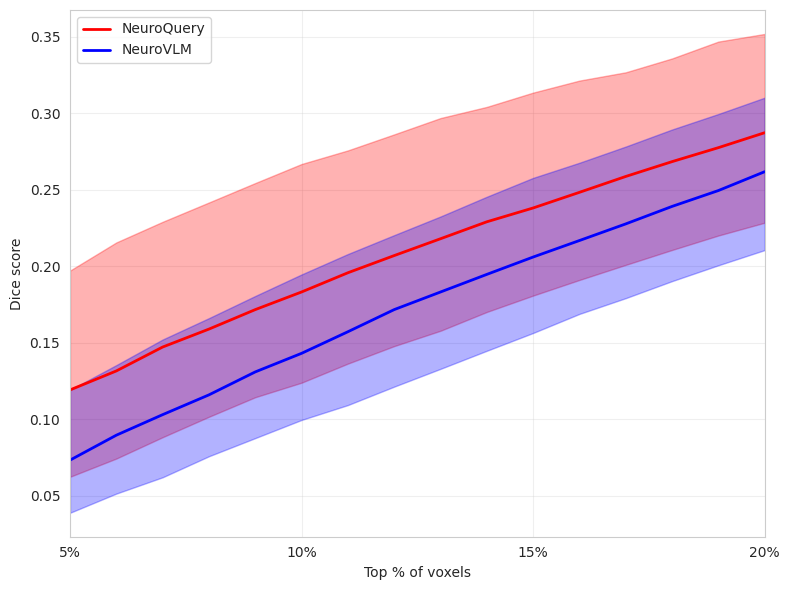

In [30]:
def dice_top_k_percent(pred_vals, true_vals, k_percent):
    """
    Compute Dice score using top k% of voxels for each subject.
    
    Args:
        pred_vals: (subjects, voxels) - predicted values
        true_vals: (subjects, voxels) - true values  
        k_percent: float - percentage of top voxels to keep (e.g., 10.0 for 10%)
    
    Returns:
        dice_scores: (subjects,) - Dice score for each subject
    """
    n_subjects, n_voxels = pred_vals.shape
    n_top_voxels = int(n_voxels * k_percent / 100)
    
    dice_scores = np.zeros(n_subjects)
    
    for i in range(n_subjects):
        # Get top k% voxels for both predicted and true
        pred_top_idx = np.argsort(pred_vals[i])[-n_top_voxels:]
        true_top_idx = np.argsort(true_vals[i])[-n_top_voxels:]
        
        # Create binary masks
        pred_mask = np.zeros(n_voxels, dtype=bool)
        true_mask = np.zeros(n_voxels, dtype=bool)
        pred_mask[pred_top_idx] = True
        true_mask[true_top_idx] = True
        
        # Compute Dice
        intersection = np.sum(pred_mask & true_mask)
        dice_scores[i] = 2 * intersection / (np.sum(pred_mask) + np.sum(true_mask))
    
    return dice_scores

def compute_dice_across_thresholds(pred_vals, true_vals, k_values):
    """Compute Dice scores across different top-k thresholds"""
    dice_scores = np.zeros((len(k_values), pred_vals.shape[0]))
    
    for i, k in enumerate(k_values):
        dice_scores[i] = dice_top_k_percent(pred_vals, true_vals, k)
    
    return dice_scores

# Define threshold range
k_values = np.arange(5, 21, 1)  

# Compute Dice scores for both methods
dice_nq_all = compute_dice_across_thresholds(pred_vals, true_nv_vals, k_values)
dice_nv_all = compute_dice_across_thresholds(preds_nv_vals, true_nv_vals, k_values)

# Compute percentiles
nq_median = np.percentile(dice_nq_all, 50, axis=1)
nq_25th = np.percentile(dice_nq_all, 25, axis=1)
nq_75th = np.percentile(dice_nq_all, 75, axis=1)

nv_median = np.percentile(dice_nv_all, 50, axis=1)
nv_25th = np.percentile(dice_nv_all, 25, axis=1)
nv_75th = np.percentile(dice_nv_all, 75, axis=1)

# Plot
plt.figure(figsize=(8, 6))

# Median lines
plt.plot(k_values, nq_median, 'r-', label='NeuroQuery', linewidth=2)
plt.plot(k_values, nv_median, 'b-', label='NeuroVLM', linewidth=2)

# Fill between 25th and 75th percentiles
plt.fill_between(k_values, nq_25th, nq_75th, alpha=0.3, color='red')
plt.fill_between(k_values, nv_25th, nv_75th, alpha=0.3, color='blue')

plt.xlabel('Top % of voxels')
plt.ylabel('Dice score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(20, 5) 
plt.gca().invert_xaxis()

# Format x-axis
plt.gca().set_xticks([20, 15, 10, 5])
plt.gca().set_xticklabels(['20%', '15%', '10%', '5%'])

plt.tight_layout()
plt.show()

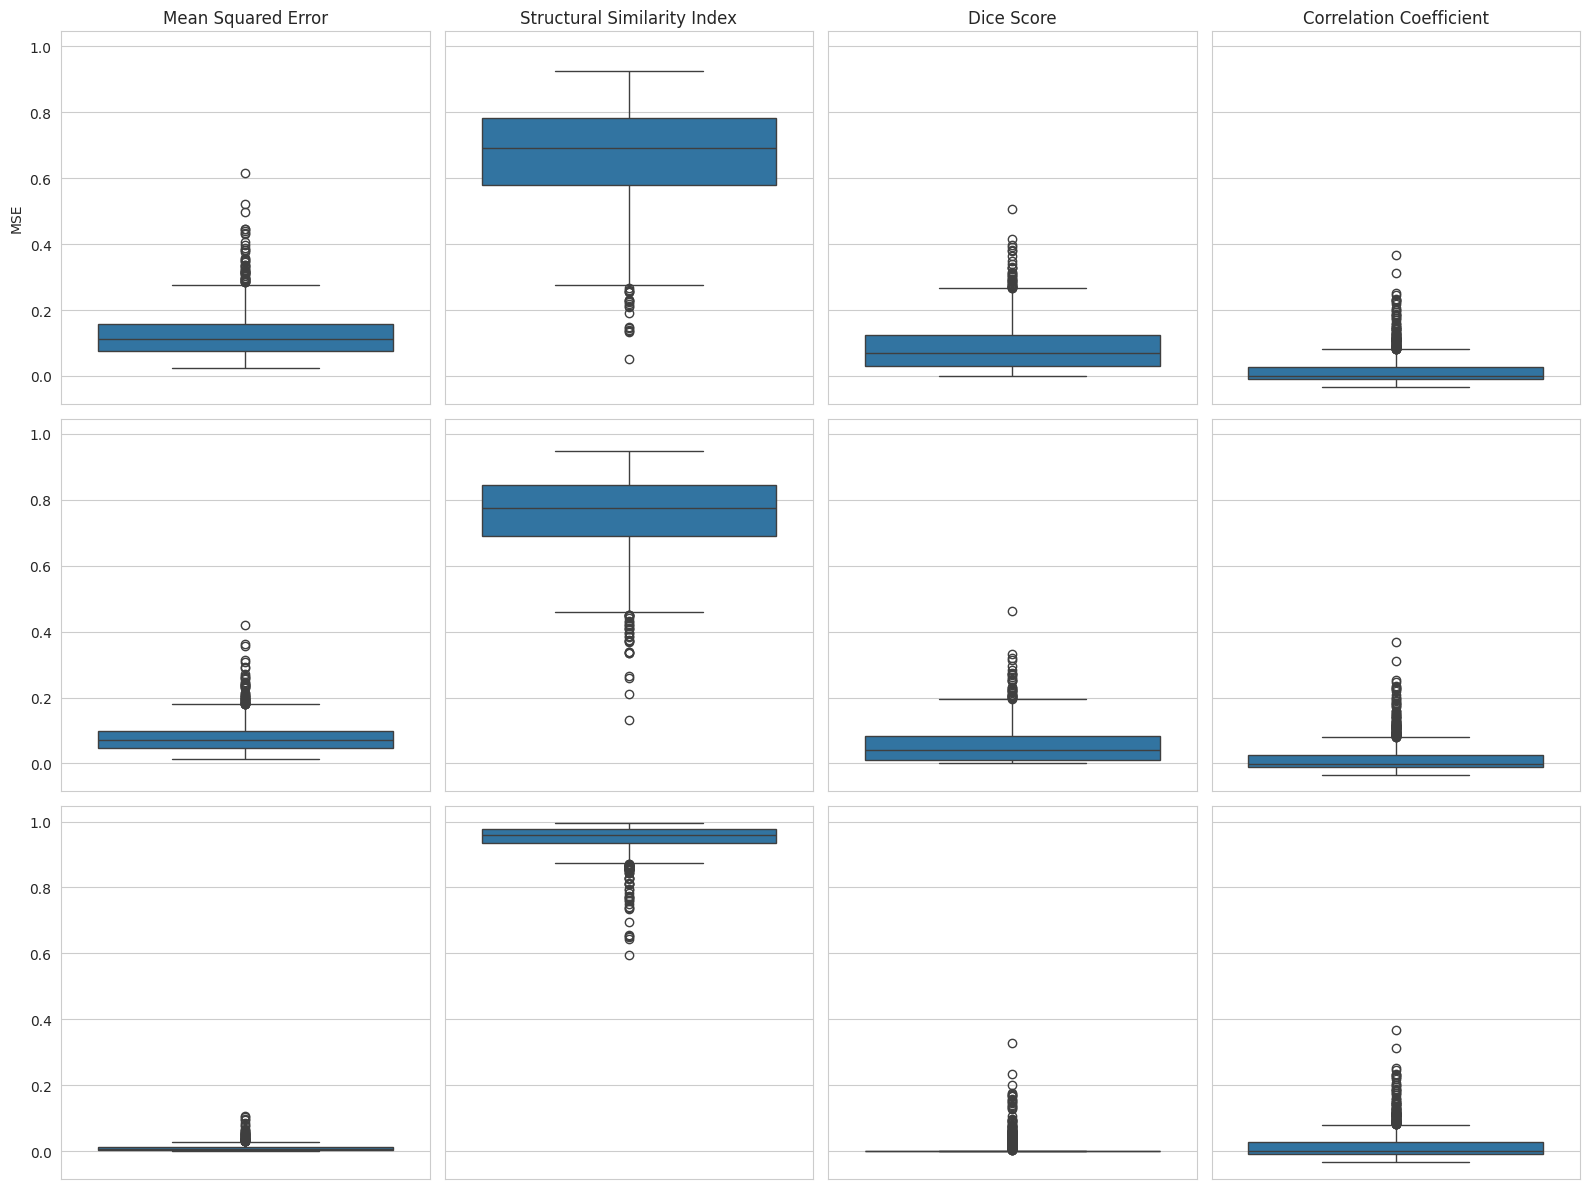

In [ ]:
# fig, axes = plt.subplots(3, 4, figsize=(16, 12), sharex=True, sharey=True)

# sns.boxplot(mse_nv[:, 0], ax=axes[0, 0])
# sns.boxplot(ssim_nv[:, 0], ax=axes[0, 1])
# sns.boxplot(dice_nv[:, 0], ax=axes[0, 2])
# sns.boxplot(r_nv, ax=axes[0, 3])

# sns.boxplot(mse_nv[:, 1], ax=axes[1, 0])
# sns.boxplot(ssim_nv[:, 1], ax=axes[1, 1])
# sns.boxplot(dice_nv[:, 1], ax=axes[1, 2])
# sns.boxplot(r_nv, ax=axes[1, 3])


# sns.boxplot(mse_nv[:, 2], ax=axes[2, 0])
# sns.boxplot(ssim_nv[:, 2], ax=axes[2, 1])
# sns.boxplot(dice_nv[:, 2], ax=axes[2, 2])
# sns.boxplot(r_nv, ax=axes[2, 3])

# axes[0, 0].set_title('Mean Squared Error')
# axes[0, 0].set_ylabel('MSE')

# axes[0, 1].set_title('Structural Similarity Index')
# axes[0, 1].set_ylabel('SSIM')
# axes[0, 2].set_title('Dice Score')
# axes[0, 2].set_ylabel('Dice')
# axes[0, 3].set_title('Correlation Coefficient')
# axes[0, 3].set_ylabel('Correlation')


# plt.tight_layout()
# # plt.savefig("neuroquery_decoding.png")

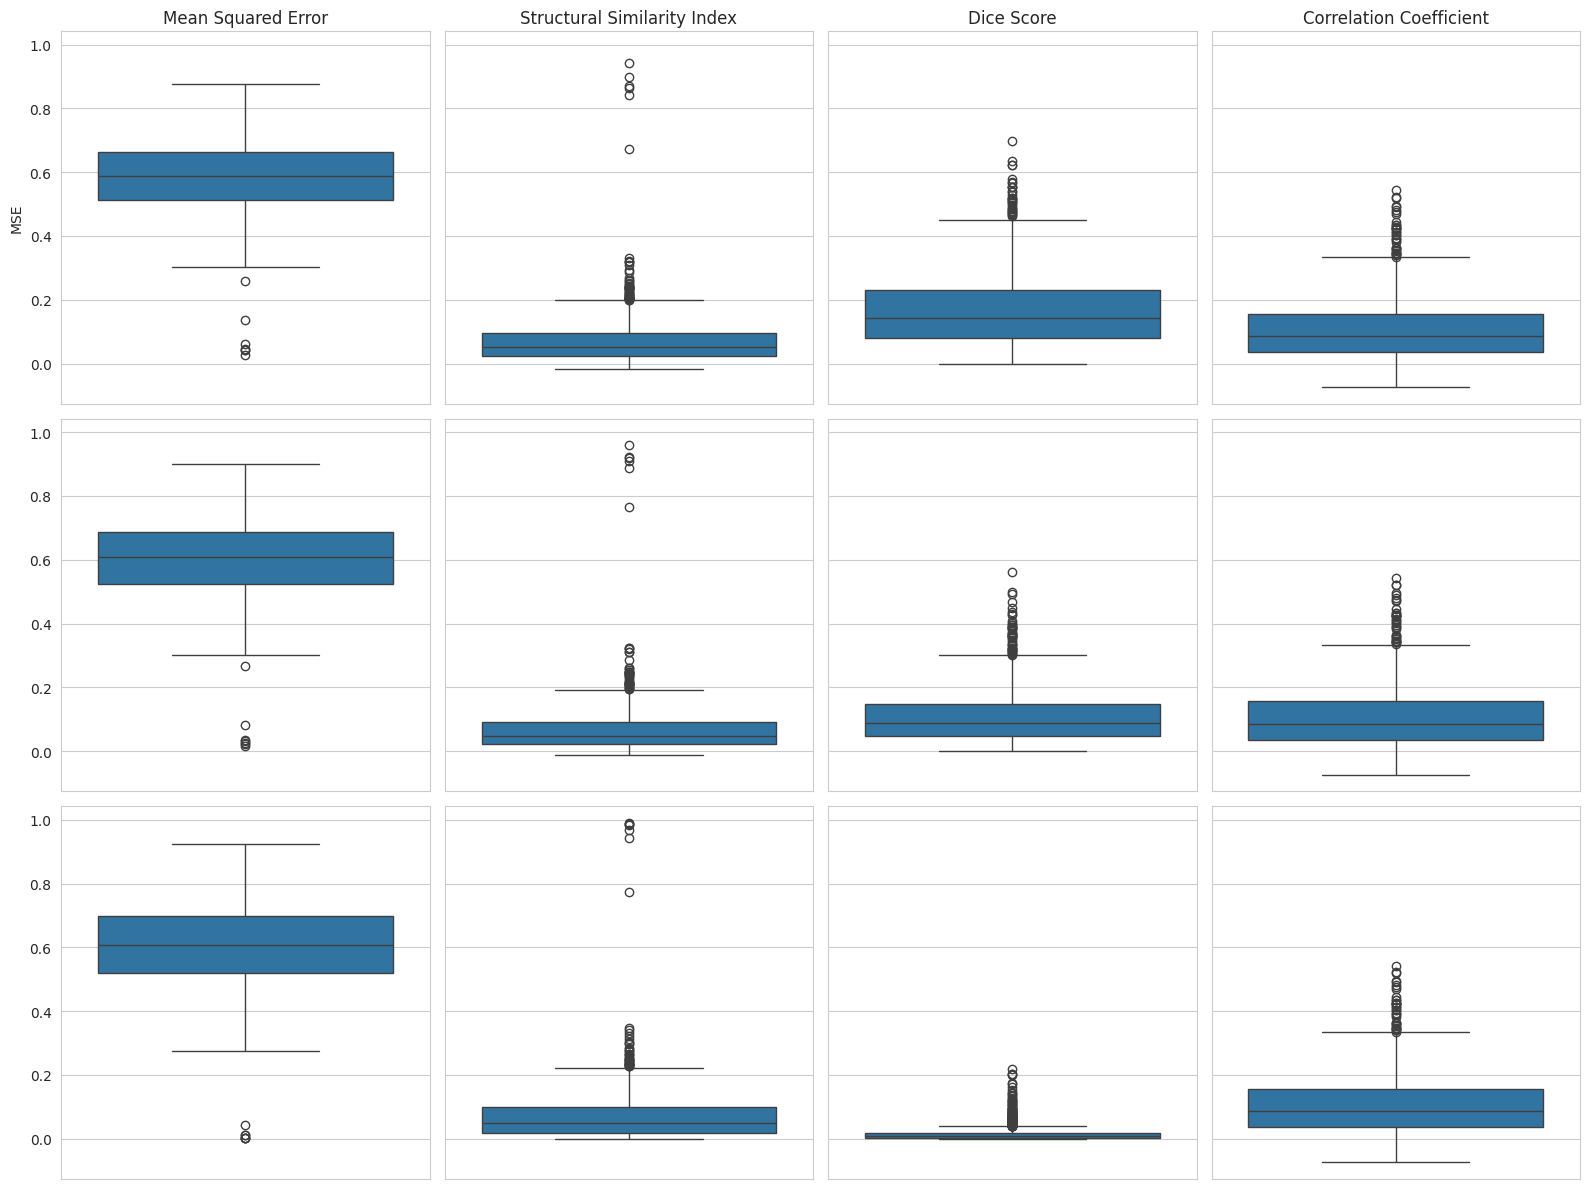

In [ ]:
# fig, axes = plt.subplots(3, 4, figsize=(16, 12), sharex=True, sharey=True)

# sns.boxplot(mse[:, 0], ax=axes[0, 0])
# sns.boxplot(ssim[:, 0], ax=axes[0, 1])
# sns.boxplot(dice[:, 0], ax=axes[0, 2])
# sns.boxplot(r, ax=axes[0, 3])

# sns.boxplot(mse[:, 1], ax=axes[1, 0])
# sns.boxplot(ssim[:, 1], ax=axes[1, 1])
# sns.boxplot(dice[:, 1], ax=axes[1, 2])
# sns.boxplot(r, ax=axes[1, 3])


# sns.boxplot(mse[:, 2], ax=axes[2, 0])
# sns.boxplot(ssim[:, 2], ax=axes[2, 1])
# sns.boxplot(dice[:, 2], ax=axes[2, 2])
# sns.boxplot(r, ax=axes[2, 3])

# axes[0, 0].set_title('Mean Squared Error')
# axes[0, 0].set_ylabel('MSE')

# axes[0, 1].set_title('Structural Similarity Index')
# axes[0, 1].set_ylabel('SSIM')
# axes[0, 2].set_title('Dice Score')
# axes[0, 2].set_ylabel('Dice')
# axes[0, 3].set_title('Correlation Coefficient')
# axes[0, 3].set_ylabel('Correlation')


# plt.tight_layout()
# # plt.savefig("neuroquery_decoding.png")